In [1]:
import os
import sys
from pathlib import  Path

import zipfile
import requests

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.model_selection import  train_test_split

import tensorflow
import tensorflow as tf

import tensorflow_datasets as tfds
import tensorflow_probability as tfp

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer

from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer
from tensorflow.keras.layers import BatchNormalization, Input, Dropout
from tensorflow.keras.layers import RandomFlip, RandomRotation, Resizing, Rescaling

from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives
from tensorflow.keras.metrics import TrueNegatives, Precision, Recall, AUC, binary_accuracy

from tensorflow.keras.optimizers import Adam, RMSprop, Adam
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers  import L2, L1

from tensorboard.plugins.hparams import api as hp

In [2]:
dataset, dataset_info = tfds.load('malaria',
                                  with_info=True,
                                  as_supervised=True,
                                  shuffle_files=True,
                                  split=['train'])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incompleteF9QGZC/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [3]:
for data in dataset[0].take(1):
  print(data)

(<tf.Tensor: shape=(145, 148, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)


In [4]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)

  train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

  val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
  val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))

  test_dataset = val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))
  return train_dataset, val_dataset, test_dataset

In [5]:
d_set = tf.data.Dataset.range(10)
print(list(d_set.as_numpy_iterator()))

ll = len(list(d_set.as_numpy_iterator()))

tr_d_set = d_set.take(int(ll*0.6))
print(list(tr_d_set.as_numpy_iterator()))

val_d_set = d_set.skip(int(ll*0.6))
val_set = val_d_set.take(int(ll*0.2))
print(list(val_set.as_numpy_iterator()))

ts_d_set = val_d_set.skip(int(ll*0.2))
print(list(ts_d_set.as_numpy_iterator()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5]
[6, 7]
[8, 9]


In [6]:
def download_zip_file(url:str, save_path:Path):
    response = requests.get(url)

    fileDir,fileName = os.path.split(save_path)

    os.makedirs(fileDir, exist_ok=True)

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        with open(save_path, 'wb') as file:
            file.write(response.content)
        print(f"Download successful. File saved at {save_path}")
    else:
        print(f"Error {response.status_code}: Unable to download the file.")


def extract_zip_file(zip_file_path, extract_path):

    fileDir, fileName = os.path.split(extract_path)
    os.makedirs(fileDir, exist_ok=True)

    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print(f"Extraction successful. Files extracted to {extract_path}")

In [7]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

train_dataset, val_dataset, test_dataset = splits(
    dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)
# print(list(train_dataset.take(1).as_numpy_iterator()),
#     list(val_dataset.take(1).as_numpy_iterator()), list(test_dataset.take(1).as_numpy_iterator()))

In [8]:
for image, label in train_dataset.take(1):
  print(image)

tf.Tensor(
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]], shape=(151, 115, 3), dtype=uint8)


In [9]:
print(list(train_dataset.take(1).as_numpy_iterator()),
    list(val_dataset.take(1).as_numpy_iterator()), list(test_dataset.take(1).as_numpy_iterator()))

[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 0)] [(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
     

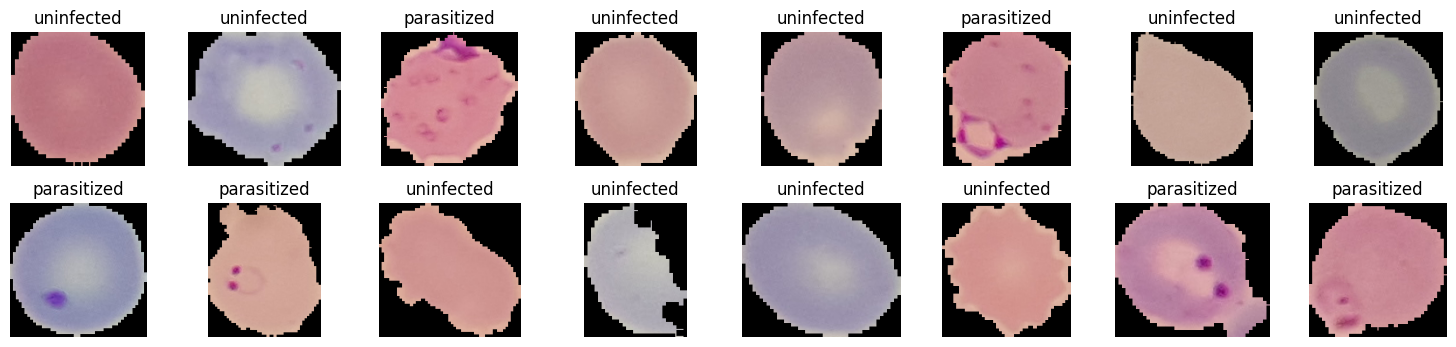

In [10]:
plt.figure(figsize=(15,7))
for i, (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4, 8, i + 1)

  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')
plt.tight_layout()
plt.show()

In [11]:
CONFIGURATION = {
    "LEARNING_RATE": 0.001,
    "N_EPOCHS": 5,
    "BATCH_SIZE": 128,
    "DROPOUT_RATE": 0.0,
    "IM_SIZE": 224,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 100,
    "N_DENSE_2": 10,
}


In [12]:
def resize_rescale(image, label, IM_SIZE=CONFIGURATION['IM_SIZE']):
    return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0,label

In [13]:
train_ = train_dataset.map(resize_rescale)
train_data = train_.shuffle(
    buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

val_ = val_dataset.map(resize_rescale)
val_data = val_.shuffle(
    buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

test_data = test_dataset.map(resize_rescale)
# test_dataset = test_dataset.shuffle(
#     buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

In [14]:
for image, label in train_data.take(1):
    print(image)

tf.Tensor(
[[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]


 [[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
 

In [15]:
model = tf.keras.Sequential([
    InputLayer(input_shape=(224,224,3)),

    tf.keras.layers.Conv2D(filters=6, kernel_size=5, strides=(
        1, 1), padding='valid', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2,2), padding='valid'),

    tf.keras.layers.Conv2D(filters=16, kernel_size=5, strides=(
        1, 1), padding='valid', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2,2), padding='valid'),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 6)       456       
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 106, 106, 16)      2416      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 53, 53, 16)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 44944)             0         
                                                                 
 dense (Dense)               (None, 256)               1

In [16]:
lenet_model = tf.keras.Sequential([
    InputLayer(input_shape=(224,224,3)),

    tf.keras.layers.Conv2D(filters=6, kernel_size=5, strides=(
        1, 1), padding='valid', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2,2), padding='valid'),

    tf.keras.layers.Conv2D(filters=16, kernel_size=5, strides=(
        1, 1), padding='valid', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2,2), padding='valid'),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(84, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

lenet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 220, 220, 6)       456       
                                                                 
 batch_normalization (Batch  (None, 220, 220, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 110, 110, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 16)      2416      
                                                                 
 batch_normalization_1 (Bat  (None, 106, 106, 16)      64        
 chNormalization)                                                
                                                      

In [17]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['binary_accuracy'])

In [18]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    verbose=2)

Epoch 1/10
689/689 - 79s - loss: 0.5286 - binary_accuracy: 0.7315 - val_loss: 0.3705 - val_binary_accuracy: 0.8356 - 79s/epoch - 115ms/step
Epoch 2/10
689/689 - 49s - loss: 0.2718 - binary_accuracy: 0.8933 - val_loss: 0.2130 - val_binary_accuracy: 0.9151 - 49s/epoch - 71ms/step
Epoch 3/10
689/689 - 54s - loss: 0.1872 - binary_accuracy: 0.9304 - val_loss: 0.1974 - val_binary_accuracy: 0.9249 - 54s/epoch - 78ms/step
Epoch 4/10
689/689 - 46s - loss: 0.1488 - binary_accuracy: 0.9470 - val_loss: 0.1972 - val_binary_accuracy: 0.9245 - 46s/epoch - 67ms/step
Epoch 5/10
689/689 - 49s - loss: 0.1195 - binary_accuracy: 0.9575 - val_loss: 0.2176 - val_binary_accuracy: 0.9158 - 49s/epoch - 71ms/step
Epoch 6/10
689/689 - 44s - loss: 0.0929 - binary_accuracy: 0.9684 - val_loss: 0.2043 - val_binary_accuracy: 0.9223 - 44s/epoch - 65ms/step
Epoch 7/10
689/689 - 49s - loss: 0.0699 - binary_accuracy: 0.9768 - val_loss: 0.2079 - val_binary_accuracy: 0.9249 - 49s/epoch - 71ms/step
Epoch 8/10
689/689 - 40s -

In [19]:
test_data_final = test_data.batch(1)
test_data_final

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [20]:
model.evaluate(test_data_final)

2757/2757 [==============================] - 20s 3ms/step - loss: 0.3754 - binary_accuracy: 0.8945


[0.3754134476184845, 0.8944504857063293]

In [21]:
model.predict(test_data_final.take(1))[0][0]

1/1 [==============================] - 11s 11s/step


2.040249e-05

In [22]:
lenet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['binary_accuracy'])

In [23]:
history_lenet = lenet_model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    verbose=2)

Epoch 1/10
689/689 - 46s - loss: 0.4729 - binary_accuracy: 0.7748 - val_loss: 0.3517 - val_binary_accuracy: 0.8526 - 46s/epoch - 66ms/step
Epoch 2/10
689/689 - 43s - loss: 0.2826 - binary_accuracy: 0.8856 - val_loss: 0.2879 - val_binary_accuracy: 0.8857 - 43s/epoch - 62ms/step
Epoch 3/10
689/689 - 53s - loss: 0.2152 - binary_accuracy: 0.9159 - val_loss: 0.2342 - val_binary_accuracy: 0.9082 - 53s/epoch - 76ms/step
Epoch 4/10
689/689 - 44s - loss: 0.1647 - binary_accuracy: 0.9370 - val_loss: 0.2603 - val_binary_accuracy: 0.9024 - 44s/epoch - 64ms/step
Epoch 5/10
689/689 - 43s - loss: 0.1243 - binary_accuracy: 0.9556 - val_loss: 0.2440 - val_binary_accuracy: 0.9154 - 43s/epoch - 62ms/step
Epoch 6/10
689/689 - 50s - loss: 0.0866 - binary_accuracy: 0.9715 - val_loss: 0.3005 - val_binary_accuracy: 0.9002 - 50s/epoch - 72ms/step
Epoch 7/10
689/689 - 44s - loss: 0.0700 - binary_accuracy: 0.9770 - val_loss: 0.3369 - val_binary_accuracy: 0.9176 - 44s/epoch - 63ms/step
Epoch 8/10
689/689 - 43s - 

In [24]:
lenet_model.evaluate(test_data_final)

2757/2757 [==============================] - 23s 4ms/step - loss: 0.3446 - binary_accuracy: 0.9133


[0.3446451425552368, 0.9133115410804749]

In [25]:
lenet_model.predict(test_data_final.take(1))[0][0]

1/1 [==============================] - 12s 12s/step


0.00025939656

In [26]:
for image, label in test_data_final.take(1):
  print(lenet_model.predict(image))

1/1 [==============================] - 0s 176ms/step
[[0.00472297]]


1/1 [==============================] - 0s 34ms/step


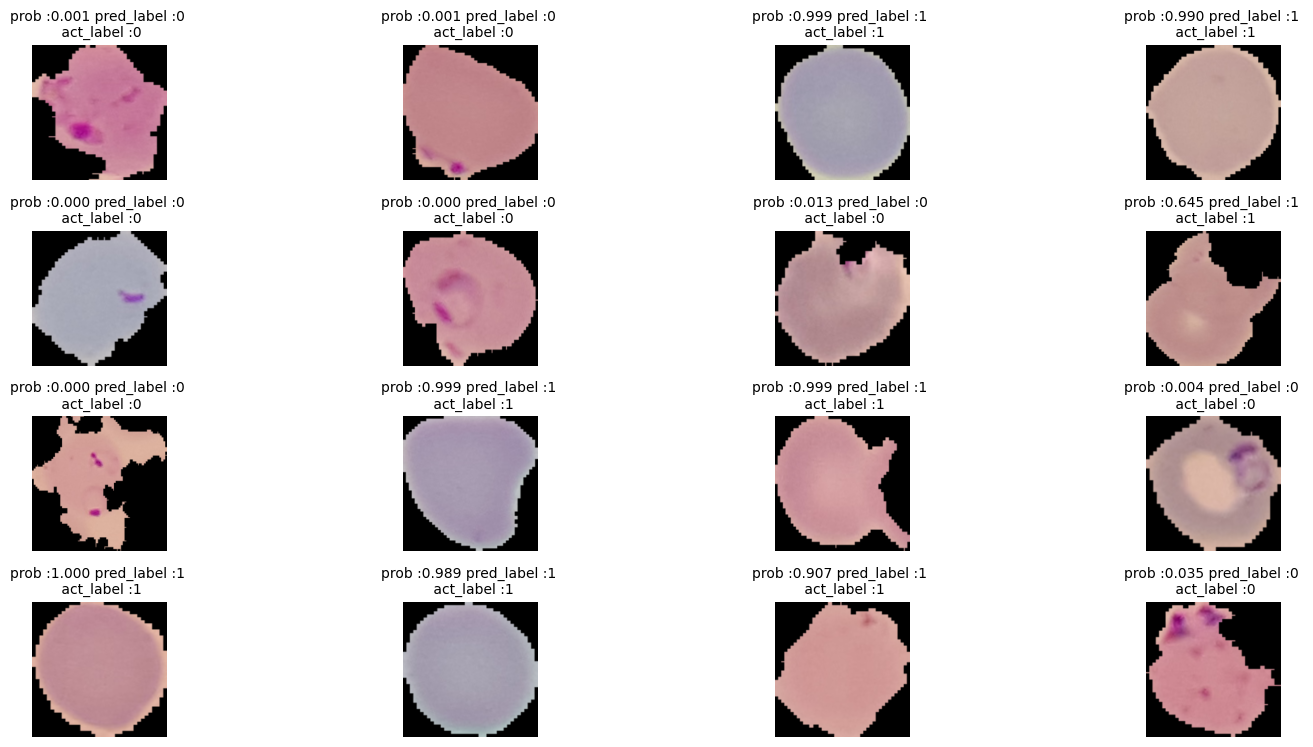

In [27]:
plt.figure(figsize=(15,15))
for i, (image, label) in enumerate(test_data_final.take(16)):
  ax = plt.subplot(8, 4, i + 1)

  plt.imshow(tf.squeeze(image,axis=0))
  pred_prob_val = lenet_model.predict(image)[0][0]
  if pred_prob_val>=0.5:
    val = 1
  else:
    val = 0
  plt.title(f"prob :{pred_prob_val:.3f} pred_label :{val} \n act_label :{label[0]}", fontsize=10)
  plt.axis('off')
plt.tight_layout()
plt.show()

In [28]:
class FeatureExtractor(Layer):
    def __init__(self,filters,kernel_size,strides,padding,activation,pool_size):
        super(FeatureExtractor,self).__init__()

        self.conv_1 = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
        self.batch_1 = tf.keras.layers.BatchNormalization()
        self.maxpool_1 = tf.keras.layers.MaxPooling2D(pool_size=pool_size, strides=strides*2, padding=padding)

        self.conv_2 = tf.keras.layers.Conv2D(filters=filters*2+4, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
        self.batch_2 = tf.keras.layers.BatchNormalization()
        self.maxpool_2 = tf.keras.layers.MaxPooling2D(pool_size=pool_size, strides=strides*2, padding=padding)

    def call(self,x, training):
        x = self.conv_1(x)
        x = self.batch_1(x)
        x = self.maxpool_1(x)

        x = self.conv_2(x)
        x = self.batch_2(x)
        x = self.maxpool_2(x)

        return x


class ModelExtractor(Model):
    def __init__(self):
        super(ModelExtractor, self).__init__()

        self.fetaure_extractor = FeatureExtractor(filters=6,
                                       kernel_size=5,
                                       strides=1,
                                       padding='valid',
                                       activation='relu',
                                       pool_size=2)

        self.flatten = tf.keras.layers.Flatten()

        self.dense_1 = tf.keras.layers.Dense(120, activation='relu')
        self.batch_1 = tf.keras.layers.BatchNormalization()
        self.dense_2 = tf.keras.layers.Dense(84, activation='relu')
        self.batch_2 = tf.keras.layers.BatchNormalization()
        self.dense_3 = tf.keras.layers.Dense(10, activation='softmax')

    def call(self, x, training):
        x = self.fetaure_extractor(x)
        x = self.flatten(x)

        x = self.dense_1(x)
        x = self.batch_1(x)

        x = self.dense_2(x)
        x = self.batch_2(x)

        x = self.dense_3(x)

        return x

feature_sub_classed = FeatureExtractor(filters=6,
                                       kernel_size=5,
                                       strides=1,
                                       padding='valid',
                                       activation='relu',
                                       pool_size=2)

model_sub_classed = ModelExtractor()

In [29]:
func_input = Input(shape=(28, 28, 1), name="Input Image")

func_output = model_sub_classed(func_input)

lenet_model_sub_classed = Model(func_input, func_output, name="Lenet_Model_sub_classed")

lenet_model_sub_classed.summary()

Model: "Lenet_Model_sub_classed"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 28, 28, 1)]       0         
                                                                 
 model_extractor (ModelExtr  (None, 10)                45330     
 actor)                                                          
                                                                 
Total params: 45330 (177.07 KB)
Trainable params: 44878 (175.30 KB)
Non-trainable params: 452 (1.77 KB)
_________________________________________________________________
